In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = '{:.2f}'.format

from statsmodels.graphics.tsaplots import plot_acf
from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from test_normal import *
from time_series import *
from cross_validation import *


warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [3]:
# Filtern nach Store
store_number = 2
store = df[df['store'] == store_number].copy()

# Datum als Index setzen
store.set_index('date', inplace=True)

# Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

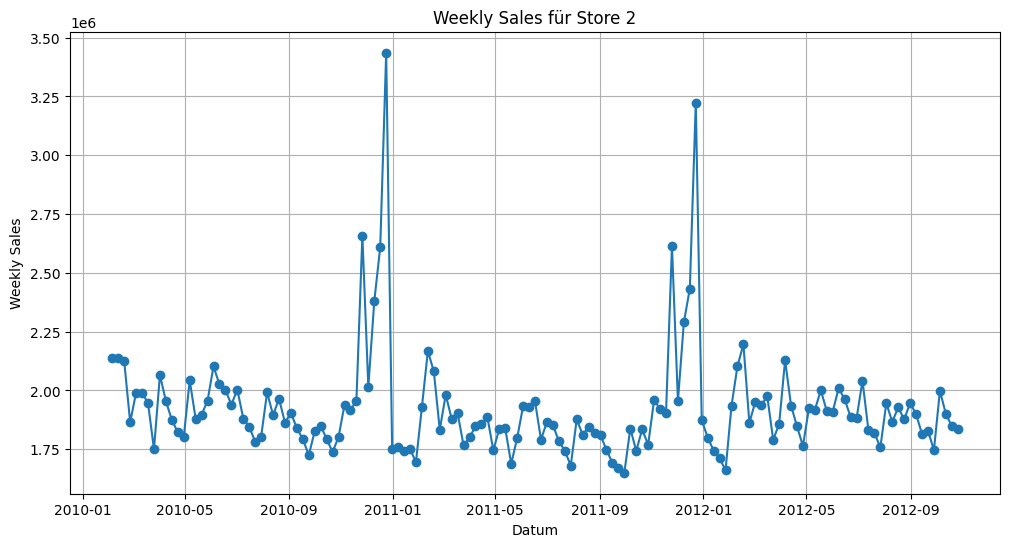

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Weekly Sales für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

Seasonal

In [5]:
#seasonal_plot(sales)
#seasonal_subseries_plot(sales)
#acf_plot(sales)
#lag_plot(sales)
#decompose(sales)

Modell wählen

In [6]:
model_type = 'SARIMA'
#model_type = 'Naive'

Residuen und Fitted Values berechnen

In [7]:
if model_type == 'Naive':
    resid, fitted_values = build_naive_model(sales)

if model_type == 'SARIMA':
    sarima_params  = optimal_orders_5.get(str(store_number))
    order = tuple(sarima_params["order"])
    seasonal_order = tuple(sarima_params["seasonal_order"])

    sarima_model = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)
    resid = sarima_model.resid.iloc[1:]
    fitted_values = sarima_model.fittedvalues.iloc[1:]
    sarima_model.summary()

Plot

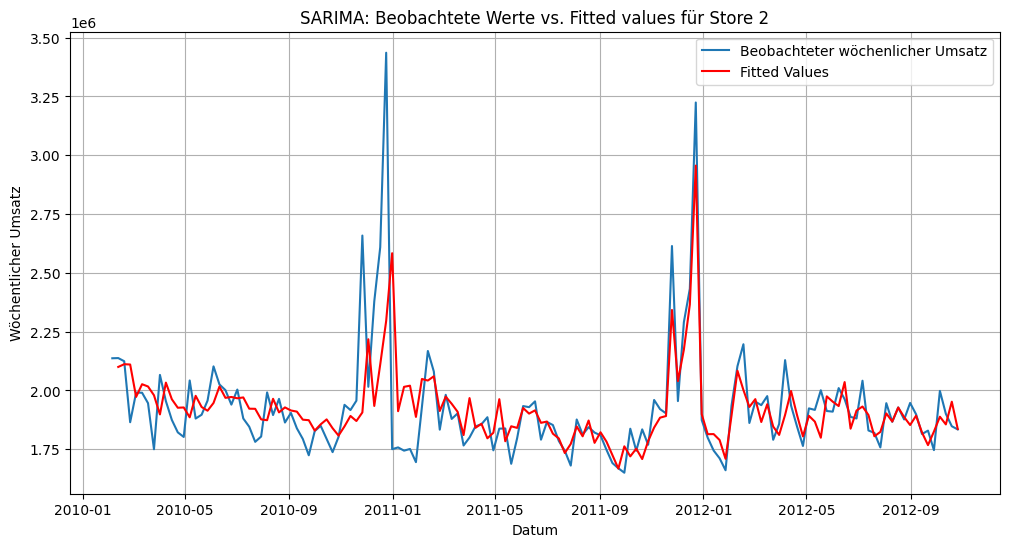

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Fitted Values')
plt.title('SARIMA: Beobachtete Werte vs. Fitted values für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()


Korrelations Tests

date
2010-02-12     37682.53
2010-02-19     12700.14
2010-02-26   -245369.32
2010-03-05     18277.65
2010-03-12    -36192.11
                ...    
2012-09-28    -79001.42
2012-10-05    109873.69
2012-10-12     44918.50
2012-10-19   -104317.38
2012-10-26     -1821.89
Freq: W-FRI, Length: 142, dtype: float64
Box Pierce Test: 0.2466
Ljung Box Test: 0.1750
Monti Test: 0.0315
Fisher Test: 0.5695
Fisher Test: 0.1809
Pena Rodriguez (m=29, N=1000): 0.0769
Breusch Godfrey: 0.9997
Run Test: 0.8451
Durbin Watson: 2.0528


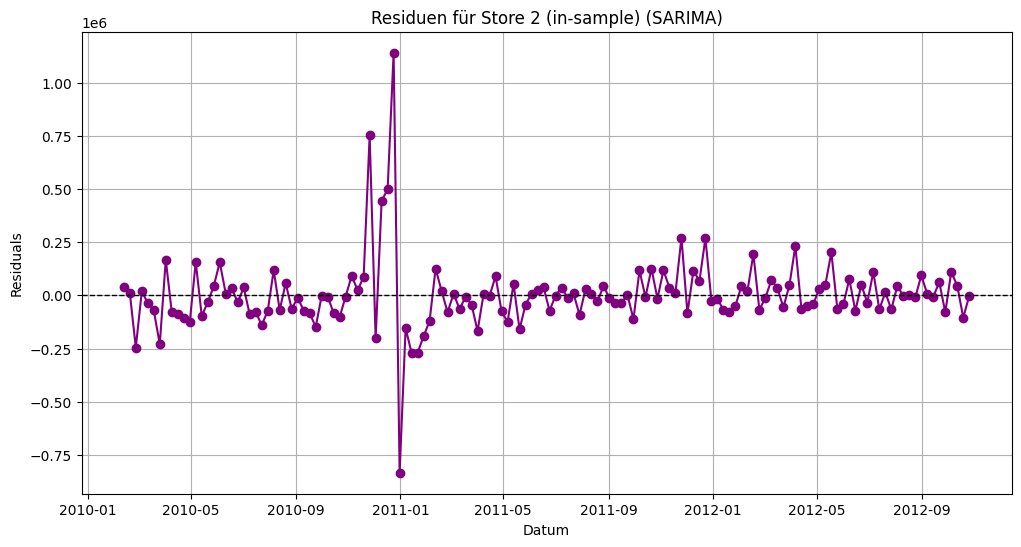

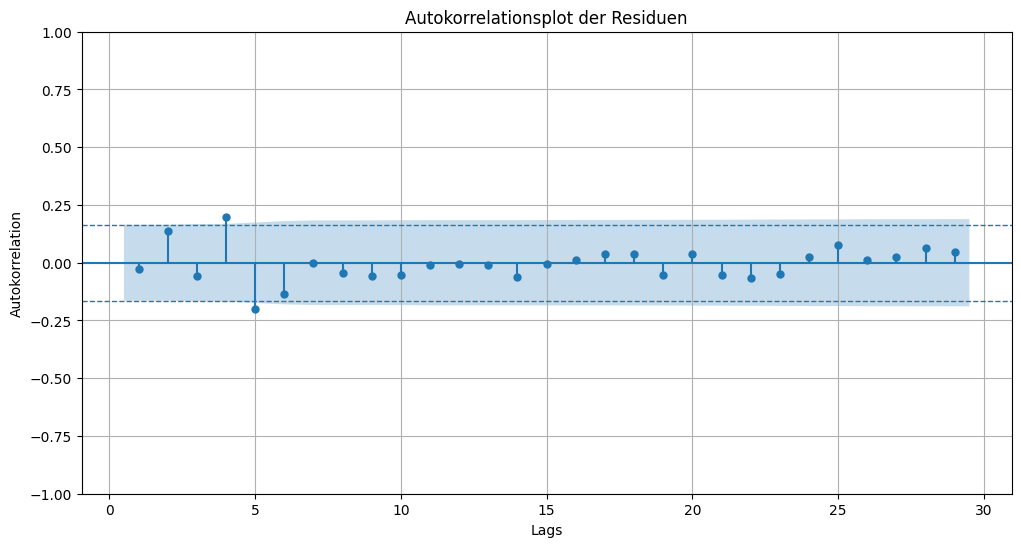

In [18]:
print(resid)
box_pierce_test(residuals = resid, store_num = store_number, model = model_type, lags = 29)
ljung_box_test(residuals = resid, store_num = store_number, model = model_type, lags = 29)
monti_test(residuals = resid, store_num = store_number, model = model_type, m = 29)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "acf", m = 29)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "pacf", m = 29)
pena_rodriguez_test_mc(residuals = resid)


if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 29)
if model_type == 'Naive':
    breusch_godfrey_test_naive(sales, lags = 5)

run_test(residuals = resid)
durbin_watson_test(residuals = resid)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(resid, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (in-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

#ACF Plot
acf_resid_plot(resid, lags = 29)



Mittelwert Tests

Mittelwert der Residuen: 3600.1862
T-Test: 0.8060
Wilcoxon Test: 0.2855
Binomial Test: 0.2752
Kolmogorov Test: 0.0001


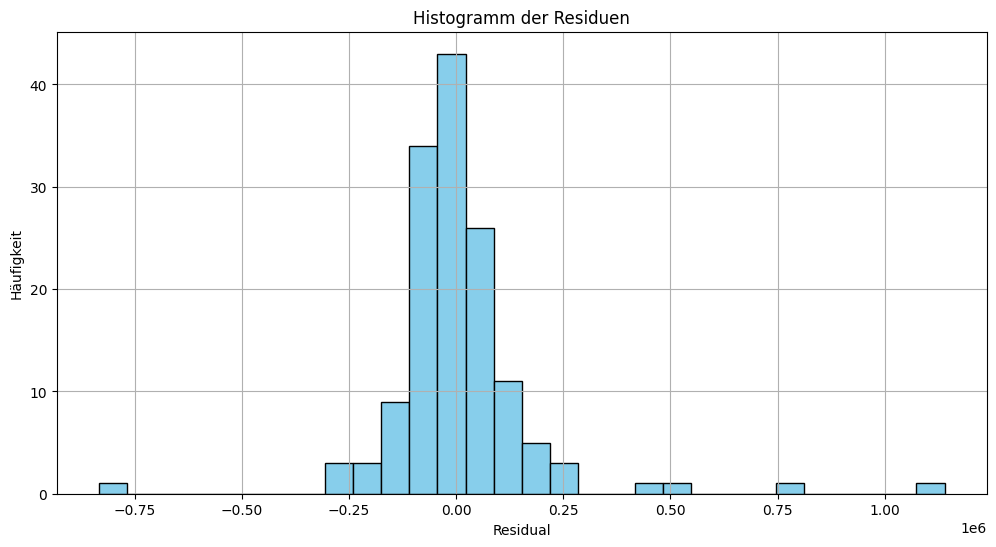

In [10]:
print(f"Mittelwert der Residuen: {resid.mean():.4f}")


t_test(resid)
wilcoxon_test(resid)
binomial_test(resid)
kolmogorov_test(resid)

hist_plot(resid)


SMAPE

In [11]:
numerator = np.abs(fitted_values - sales.iloc[1:])
denominator = (np.abs(fitted_values) + np.abs(sales.iloc[1:])) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: 4.70%


Kreuz Validierung

Cross-Validation RMSE: 76663.40615303122


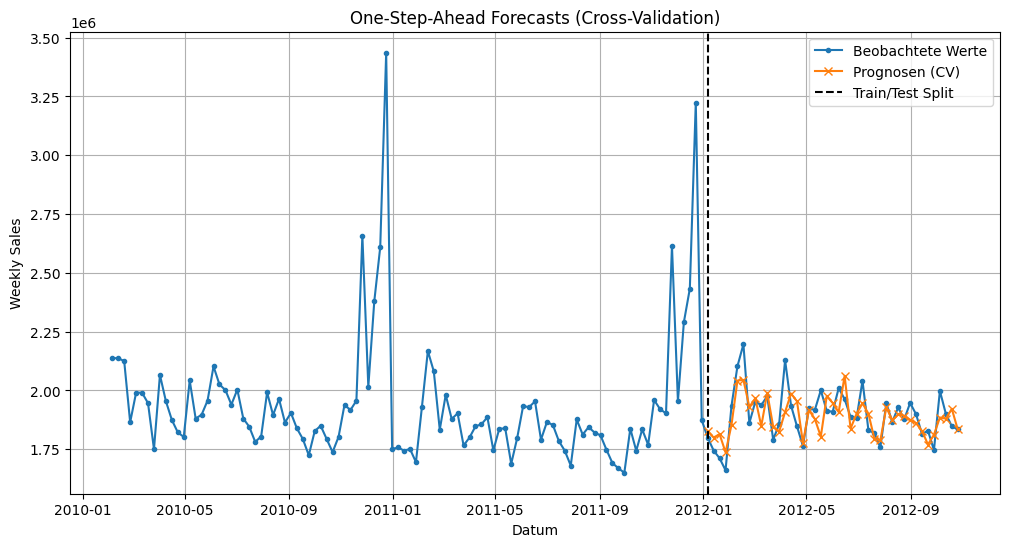

In [12]:
if model_type == 'SARIMA':
    cv_df, train_size = cross_validation_SARIMA(sales, order = order, seasonal_order = seasonal_order)
if model_type == 'Naive':
    cv_df = cross_validation_naive(sales)


Korrelations Tests

0     -28069.00
1     -55323.23
2    -102545.88
3     -75884.58
4      81291.72
5      61232.27
6     151803.80
7     -68491.09
8     -14211.93
9      88927.50
10    -14402.78
11    -56435.49
12     32233.36
13    220625.86
14    -51025.73
15   -106553.85
16    -12661.32
17      6740.02
18     38830.58
19    196613.19
20    -63100.06
21    -36575.39
22    101906.43
23    -99382.40
24     49373.47
25    -19622.34
26     95799.16
27    -71199.56
28     24960.24
29    -29592.55
30     17863.56
31     -7327.33
32     29998.96
33    -16139.16
34     71815.28
35     37858.32
36    -12858.02
37     59110.90
38    -65672.99
39    113164.98
40     20549.82
41    -74080.05
42        44.70
Name: error, dtype: float64
Box Pierce Test: nan
Ljung Box Test: nan
Monti Test: 0.0085
Fisher Test: 0.5189
Fisher Test: 0.0019
Pena Rodriguez (m=29, N=1000): 0.2488
Breusch Godfrey: 0.9997
Run Test: 0.1792
Durbin Watson: 2.2503


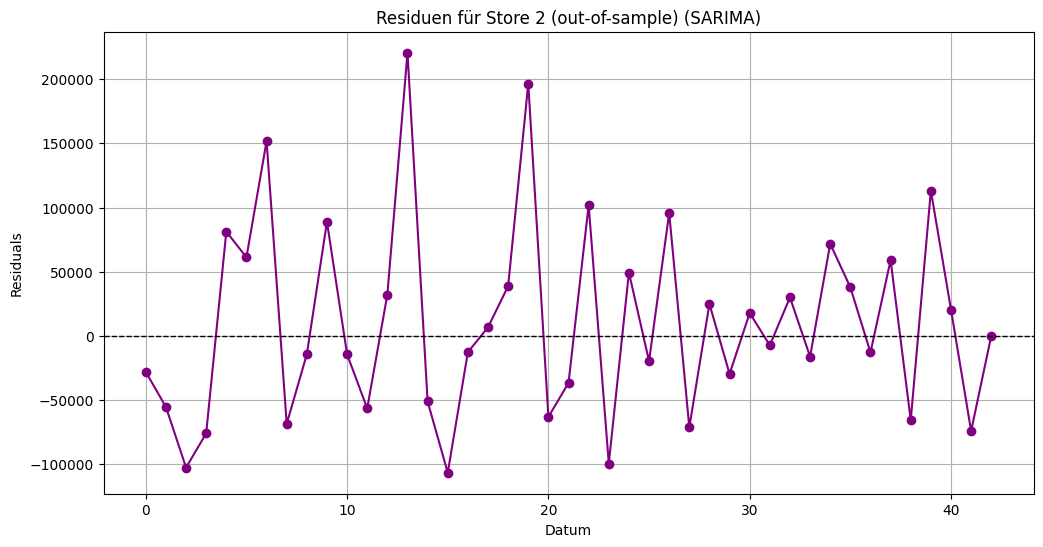

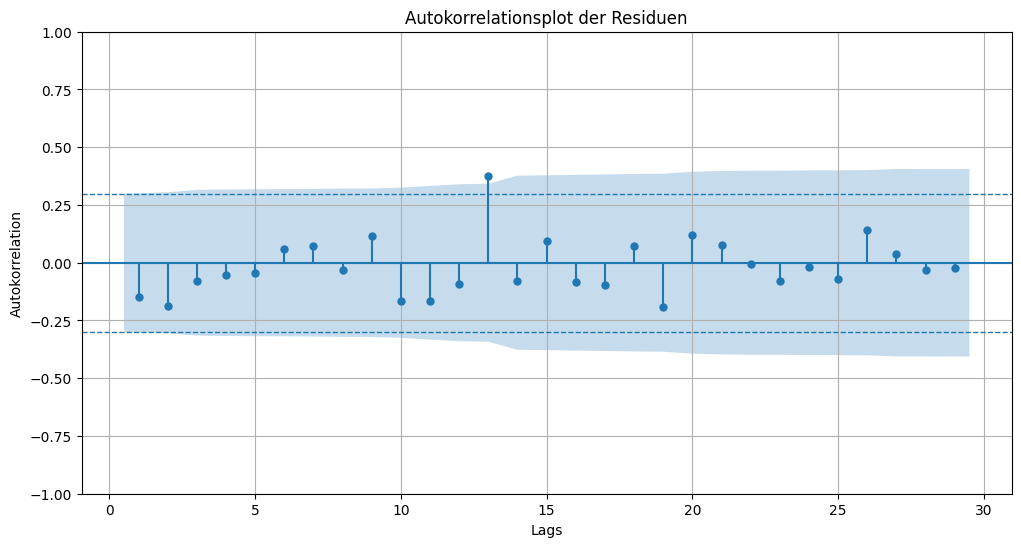

In [16]:
errors = cv_df['error']
print(errors)
box_pierce_test(residuals = errors, store_num = store_number, model = model_type, lags = 29)
ljung_box_test(residuals = errors, store_num = store_number, model = model_type, lags = 29)
monti_test(residuals = errors, store_num = store_number, model = model_type, m = 21)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "acf", m = 21)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "pacf", m = 21)
pena_rodriguez_test_mc(residuals = errors)


if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 29) #TODO: Gleich wie in-sample?
if model_type == 'Naive':
    breusch_godfrey_test_naive(sales, lags = 5)


run_test(residuals = errors)

durbin_watson_test(residuals = errors)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(errors, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (out-of-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()


acf_resid_plot(residuals = errors)


Mittelwert Tests

Mittelwert der Errors: 9757.892705818123
T-Test: 0.4103
Wilcoxon Test: 0.6888
Binomial Test: 1.0000
Kolmogorov Test: 0.7131


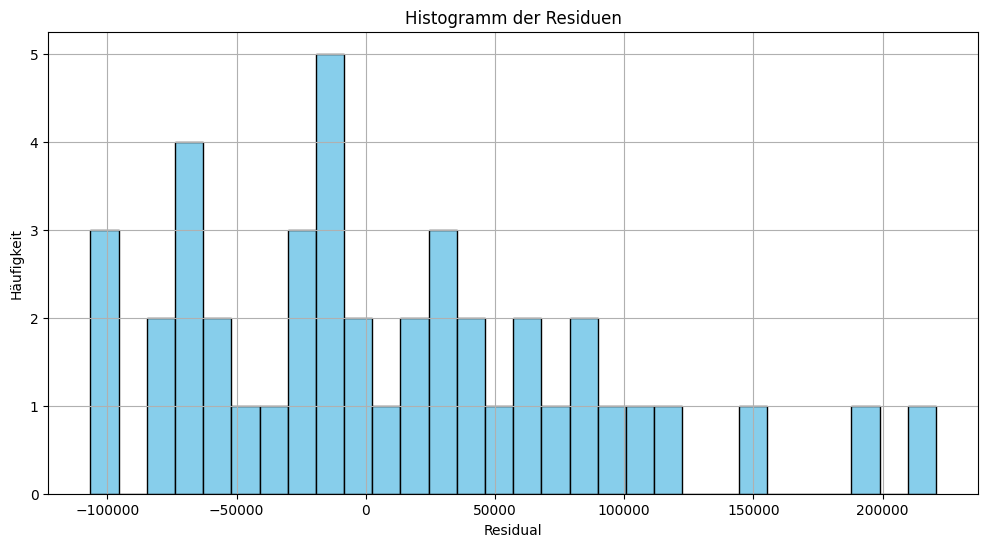

In [14]:
print(f'Mittelwert der Errors: {errors.mean()}')

t_test(errors)
wilcoxon_test(errors)
binomial_test(errors)
kolmogorov_test(errors)

hist_plot(errors)


SMAPE

In [15]:
actual_values = cv_df['actual']
forecast_values = cv_df['forecast']

numerator = np.abs(forecast_values - actual_values)
denominator = (np.abs(forecast_values) + np.abs(actual_values)) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: 3.14%
